In [1]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, sampler
import torchvision
from torchvision import transforms
import albumentations as A
from PIL import Image
import numpy as np
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
import os
from albumentations.pytorch import ToTensorV2
from utils import calc_metric, write_results,list_to_cuda, eval_model, train_one_epoch
from fusion_layer import FusionLayer 

from torchvision.models import resnet18, ResNet18_Weights


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:

def get_data_transforms():
    """
    Returns proper data augmentation for the method given as parameter.
    """
    
    #mean and std from pretrained model on imagenet
    mean = [0.485, 0.456, 0.406]
    std = [0.228, 0.224, 0.225]
    
    normalize = A.Normalize(mean=mean, std=std)
    #albumentations on training data
    train_trans = [ 
                  A.Rotate(10),
                  A.ColorJitter(hue=0.2),
                  A.RandomResizedCrop(size=(299,299), scale=(0.75, 1.0)), 
                  A.RandomToneCurve (scale=0.5, p=0.5),
                  normalize,
                  ToTensorV2()]
    #albumentations on validation data
    val_trans =  [A.Resize(height = 299, width=299),
                  normalize,
                  ToTensorV2()]
    #albumentations on testing data
    test_trans = [A.Resize(height=299, width=299),
                   normalize,
                   ToTensorV2()]


    #dict to store the transformations for each step
    data_transforms = {
        'train': A.Compose(train_trans),
        'val': A.Compose(val_trans),
        'test': A.Compose(test_trans),
    }
    
    return data_transforms

In [3]:
class BRDataset(torch.utils.data.Dataset):
    def __init__(self, labels_csv, prefix=None, transforms=None, meta_augmentations=False):
        super(BRDataset, self).__init__()
        
        self.labels_csv = labels_csv
        self.augmentations = transforms
        self.meta_augmentations = meta_augmentations
        self.prefix = prefix 
        print(labels_csv)
        self.csv = pd.read_csv(labels_csv,index_col=False) 
        self.csv.reset_index(drop=True, inplace=True)
        self.class_counts = dict(self.csv['label'].value_counts())
        classes = list(self.csv['label'].unique())
        classes.sort()
        self.class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.classes = classes

        print('Found {} images from {} classes.'.format(len(self.csv),
                                                        len(classes)))
        for class_name, idx in self.class_to_idx.items():
            n_images = dict(self.csv['label'].value_counts())
            print("    Class '{}' ({}): {} images.".format(
                class_name, idx, n_images[class_name]))
    
    def __len__(self):
        """
        returns the length of the dataframe
        """
        return len(self.csv['cropped_image_file_path'])
    
    def __getitem__(self, idx):
        """
        returns the image, appropriate metadata, and disease label in the row specified by idx
        """
        img_path = list(self.csv['cropped_image_file_path'])[idx]
       
        img = Image.open(img_path).convert("RGB")        
        img2 = np.array(img)
        label = torch.tensor(int(list(self.csv['label'])[idx]))
        if self.augmentations is not None:
            img = self.augmentations(image=img2)["image"]
            
        #Extracting metadata features
        mass_shape = list(self.csv['mass_shape'])[idx]
        mass_shape =  torch.tensor(int(mass_shape))
        mass_margins = list(self.csv['mass_margins'])[idx]
        mass_margins =  torch.tensor(int(mass_margins))
        breast_density = list(self.csv['breast_density'])[idx]
        breast_density =  torch.tensor(int(breast_density))
        assessment = list(self.csv['assessment'])[idx]
        assessment =  torch.tensor(int(assessment))
        subtlety = list(self.csv['subtlety'])[idx]
        subtlety =  torch.tensor(int(subtlety))
        abnormality_id = list(self.csv['abnormality_id'])[idx]
        abnormality_id =  torch.tensor(int(abnormality_id))
         
        metadata = (mass_shape, mass_margins, breast_density,assessment,subtlety,abnormality_id)
        return img, metadata, label    
     

In [4]:
data_transforms = get_data_transforms()
batch_size = 32
batch_size_test = 32
lr = 0.0001 



#Creating train validation and test sets, change path accordingly for each cross validation split
BR_train_ds = BRDataset('C:\\Users\\preet\\Documents\\breast_cancer\\csv\\processed_mass_train_5.csv',transforms=data_transforms['train'])
BR_val_ds  =  BRDataset('C:\\Users\\preet\\Documents\\breast_cancer\\csv\\processed_mass_val_5.csv',transforms=data_transforms['val'])
BR_test_ds  =  BRDataset('C:\\Users\\preet\\Documents\\breast_cancer\\csv\\processed_mass_test.csv',transforms=data_transforms['test'])

#Creating the dataloaders
train_sampler = None
train_loader = DataLoader(BR_train_ds, batch_size=batch_size, shuffle=train_sampler is None,
                          pin_memory=True, num_workers=0, sampler=train_sampler)
test_loader = DataLoader(BR_test_ds, batch_size=batch_size, shuffle=False,
                          pin_memory=True, num_workers=0)
val_loader = DataLoader(BR_val_ds, batch_size=batch_size, shuffle=False,
                          pin_memory=True, num_workers=0)


        
#Models

#Baseline approach (no metadata information)
class resnet_model(torch.nn.Module):
    def __init__(self, enable_gates=False):
        super(resnet_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
   
        self.classifier = nn.Linear(2048, 3)
        self.enable_gates = enable_gates
     
    def forward(self, x, x_metadata):
        x=self.encoder(x)
        y= self.classifier(x)
        return y

#concatenation approach
class resnet_concat_model(torch.nn.Module):
    def __init__(self):
        super(resnet_concat_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
        self.mass_shape_emb = nn.Embedding(20, 16)
        self.mass_margins_emb = nn.Embedding(19, 16)
        self.breast_density_emb = nn.Embedding(5, 16)
        self.assessment_emb = nn.Embedding(6, 16)
        self.subtlety_emb = nn.Embedding(6, 16)
        self.abnormality_id_emb = nn.Embedding(7, 16)
        self.classifier = nn.Linear(2048+6*16, 3)
 

    def forward(self, x, x_metadata):
        (mass_shape, mass_margins, breast_density,assessment,subtlety,abnormality_id) = x_metadata
        x=self.encoder(x)
        x1 = self.mass_shape_emb(mass_shape)
        x2 = self.mass_margins_emb(mass_margins)
        x3 = self.breast_density_emb(breast_density)
        x4 = self.assessment_emb(assessment)
        x5 = self.subtlety_emb(subtlety)
        x6 = self.abnormality_id_emb(abnormality_id)
        x_all = torch.cat((x,x1,x2,x3,x3,x5,x6),dim=1)
        y = self.classifier(x_all)
        return y


#Metanet architecture
class resnet_metanet_model(torch.nn.Module):
    def __init__(self, enable_gates=False):
        super(resnet_metanet_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
        self.linear = nn.Linear(20+19+5+6+6+7,2048)
        self.classifier = nn.Linear(2048, 3)
        self.enable_gates = enable_gates
        
    def forward(self, x, x_metadata):
        (mass_shape, mass_margins, breast_density,assessment,subtlety,abnormality_id) = x_metadata
        x=self.encoder(x)
        mass_shape = torch.nn.functional.one_hot(mass_shape, num_classes=20)
        mass_margins = torch.nn.functional.one_hot(mass_margins, num_classes=19)
        breast_density = torch.nn.functional.one_hot(breast_density, num_classes=5)
        assessment = torch.nn.functional.one_hot(assessment, num_classes=6)
        subtlety = torch.nn.functional.one_hot(subtlety, num_classes=6)
        abnormality_id = torch.nn.functional.one_hot(abnormality_id, num_classes=7)
        x_meta = torch.cat((mass_shape, mass_margins, breast_density,assessment,subtlety,abnormality_id),dim=1)
        y = self.linear(x_meta.float())
        y = F.sigmoid(y)
        x = x*y
        y= self.classifier(x)
        return y
        

#Metablock architecture
class resnet_metablock_model(torch.nn.Module):
    def __init__(self, enable_gates=False):
        super(resnet_metablock_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)
        self.linear1 = nn.Linear(20+19+5+6+6+7,2048)
        self.linear2 = nn.Linear(20+19+5+6+6+7,2048)
        self.classifier = nn.Linear(2048, 3)
        self.enable_gates = enable_gates
        
    def forward(self, x, x_metadata):
        (mass_shape, mass_margins, breast_density,assessment,subtlety,abnormality_id) = x_metadata
        x=self.encoder(x)
        mass_shape = torch.nn.functional.one_hot(mass_shape, num_classes=20)
        mass_margins = torch.nn.functional.one_hot(mass_margins, num_classes=19)
        breast_density = torch.nn.functional.one_hot(breast_density, num_classes=5)
        assessment = torch.nn.functional.one_hot(assessment, num_classes=6)
        subtlety = torch.nn.functional.one_hot(subtlety, num_classes=6)
        abnormality_id = torch.nn.functional.one_hot(abnormality_id, num_classes=7)
        x_meta = torch.cat((mass_shape, mass_margins, breast_density,assessment,subtlety,abnormality_id),dim=1)
        y1 = self.linear1(x_meta.float())
        y2 = self.linear2(x_meta.float())
        x = F.sigmoid(F.tanh(x*y1)+y2)
        y= self.classifier(x)
        return y



#MetaFusion novel approach 
class meta_fusion_model(torch.nn.Module):
    def __init__(self):
        super(meta_fusion_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,2048)

  
        self.mass_shape_emb = nn.Embedding(20, 16)
        self.mass_margins_emb = nn.Embedding(19, 16)
        self.breast_density_emb = nn.Embedding(5, 16)
        self.assessment_emb = nn.Embedding(6, 16)
        self.subtlety_emb = nn.Embedding(6, 16)
        self.abnormality_id_emb = nn.Embedding(7, 16)
        self.classifier = nn.Linear(2048+6*16, 3)
        
        self.mass_shape_gate1 = FusionLayer(16, 2048)
        self.mass_margins_gate1 = FusionLayer(16, 2048)
        self.breast_density_gate1 = FusionLayer(16, 2048)
        self.assessment_gate1 = FusionLayer(16, 2048)
        self.subtlety_gate1 = FusionLayer(16, 2048)
        self.abnormality_id_gate1 = FusionLayer(16, 2048)
        self.image_gate1 = FusionLayer(2048, 16*6)  

    def forward(self, x, x_metadata):
        (mass_shape, mass_margins, breast_density,assessment,subtlety,abnormality_id) = x_metadata
        x=self.encoder(x)
        x_mass_shape = self.mass_shape_emb(mass_shape)
        x_mass_margins = self.mass_margins_emb(mass_margins)
        x_breast_density = self.breast_density_emb(breast_density)
        x_assessment = self.assessment_emb(assessment)
        x_subtlety = self.subtlety_emb(subtlety)
        x_abnormality_id= self.abnormality_id_emb(abnormality_id)
        #modify metadata
        x_all = torch.cat((x_mass_shape,x_mass_margins,x_breast_density,x_assessment,x_subtlety,x_abnormality_id),dim=1)
        x_all = x_all + self.image_gate1(x_all,x)

        #modify image
        x1 = x + self.mass_shape_gate1(x, x_mass_shape)
        x2 = x1 + self.mass_margins_gate1(x, x_mass_margins)
        x3 = x2 + self.breast_density_gate1(x, x_breast_density)
        x4 = x3 + self.assessment_gate1(x, x_assessment)
        x5 = x4 + self.subtlety_gate1(x, x_subtlety)
        x6 = x5 + self.abnormality_id_gate1(x, x_abnormality_id)


        # Final classifier
        x_out = torch.cat((x6,x_all),dim=1)
        y = self.classifier(x_out)
        return y
    


C:\Users\preet\Documents\breast_cancer\csv\processed_mass_train_5.csv
Found 1054 images from 3 classes.
    Class '0' (0): 502 images.
    Class '1' (1): 84 images.
    Class '2' (2): 468 images.
C:\Users\preet\Documents\breast_cancer\csv\processed_mass_val_5.csv
Found 264 images from 3 classes.
    Class '0' (0): 135 images.
    Class '1' (1): 20 images.
    Class '2' (2): 109 images.
C:\Users\preet\Documents\breast_cancer\csv\processed_mass_test.csv
Found 378 images from 3 classes.
    Class '0' (0): 147 images.
    Class '1' (1): 37 images.
    Class '2' (2): 194 images.


C:\ProgramData\Anaconda3\envs\pt21p\lib\site-packages\pydantic\main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.42it/s]


LR [9.990232305719945e-05]
Trn Loss 0.9428848
Balanced ACC 0.40631288440053376
Confusion matrix [[299  14 189]
 [ 36   3  45]
 [178  15 275]]
Acc 0.547438330170778
Saving model for epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.43it/s]


Loss 0.8822169
Balanced ACC 0.41162079510703364
Confusion matrix [[54  0 81]
 [ 3  0 17]
 [18  0 91]]
Acc 0.5492424242424242


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.49it/s]


Loss 0.9329918
Balanced ACC 0.41605301914580267
Confusion matrix [[ 63   0  84]
 [ 10   0  27]
 [ 35   0 159]]
Acc 0.5873015873015873
[0.9428848]
['test_acc', 'test_ba', 'test_loss', 'trn_acc', 'trn_ba', 'trn_loss', 'val_acc', 'val_ba', 'val_loss']


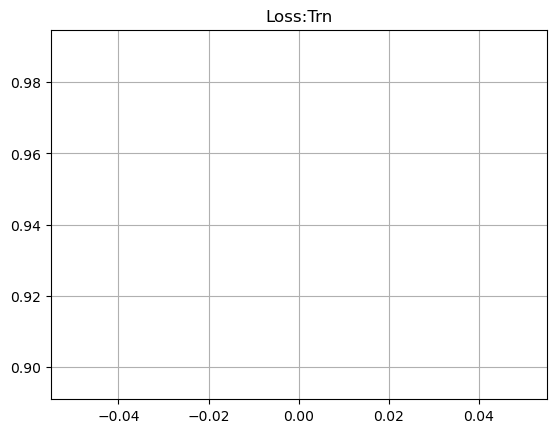

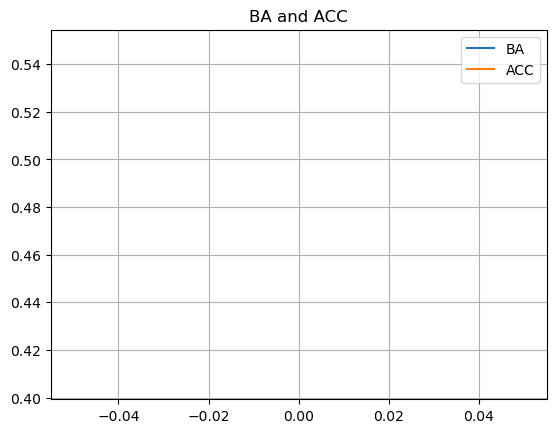

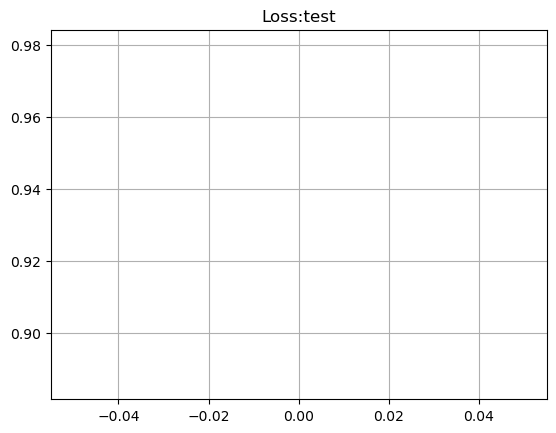

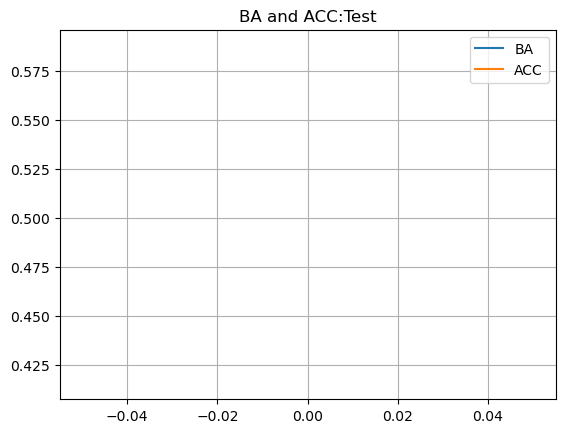

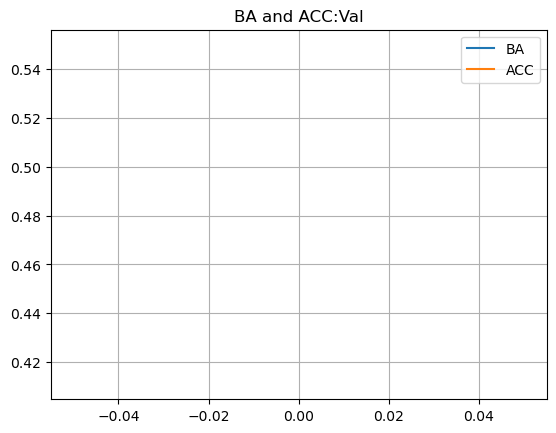

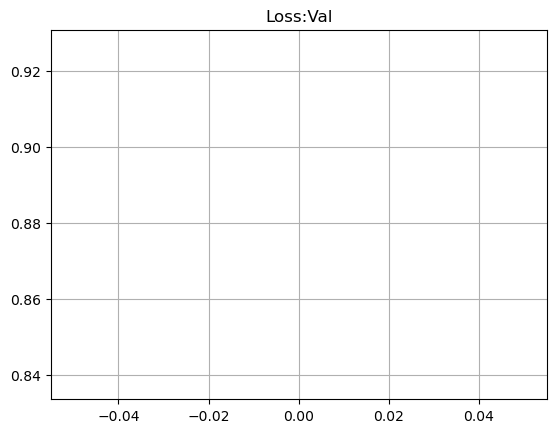

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.49it/s]


LR [9.990232305719945e-05]
Trn Loss 0.95076
Balanced ACC 0.3696723079193199
Confusion matrix [[295   9 198]
 [ 46   0  38]
 [214  10 244]]
Acc 0.5113851992409867
Saving model for epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.63it/s]


Loss 0.8093266
Balanced ACC 0.45228225167063085
Confusion matrix [[94  0 41]
 [ 9  0 11]
 [37  0 72]]
Acc 0.6287878787878788


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.11it/s]


Loss 0.93605393
Balanced ACC 0.41747901909904855
Confusion matrix [[100   0  47]
 [ 20   0  17]
 [ 83   0 111]]
Acc 0.5582010582010583
[0.95076]
['test_acc', 'test_ba', 'test_loss', 'trn_acc', 'trn_ba', 'trn_loss', 'val_acc', 'val_ba', 'val_loss']


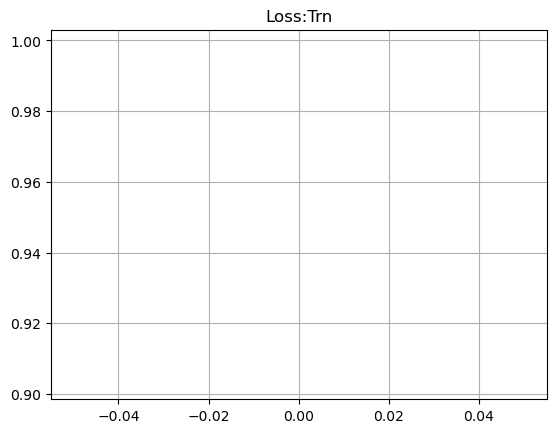

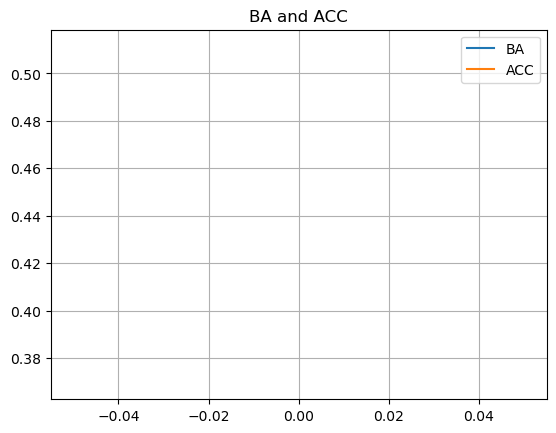

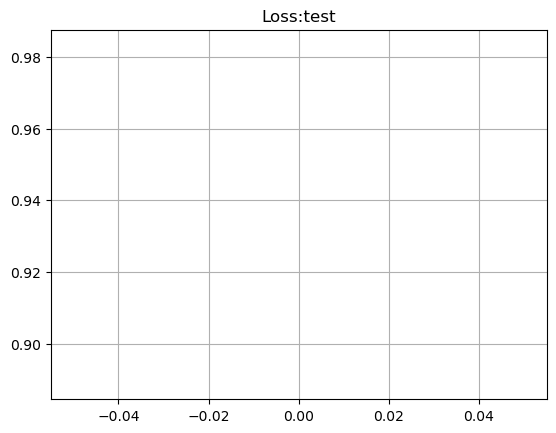

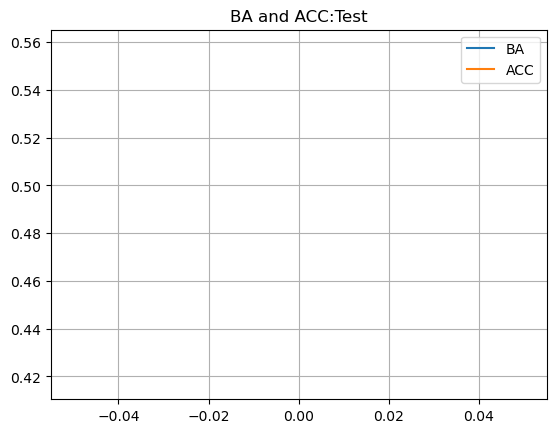

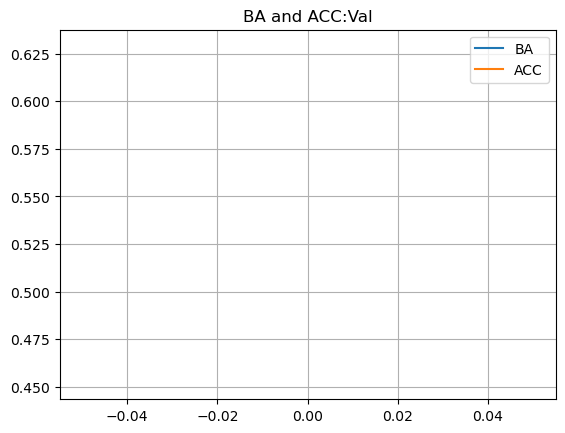

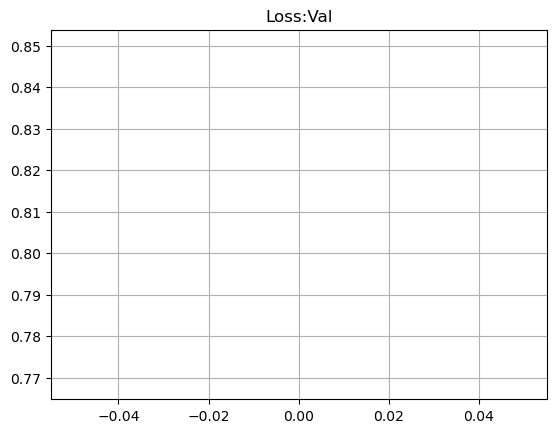

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:09<00:00,  3.61it/s]


LR [9.990232305719945e-05]
Trn Loss 0.9036352
Balanced ACC 0.3925608108875041
Confusion matrix [[293   3 206]
 [ 33   0  51]
 [189   1 278]]
Acc 0.5417457305502846
Saving model for epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.17it/s]


Loss 0.8208215
Balanced ACC 0.4253482840638804
Confusion matrix [[93  0 42]
 [ 6  0 14]
 [45  0 64]]
Acc 0.5946969696969697


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.24it/s]


Loss 0.8996217
Balanced ACC 0.4116347569955818
Confusion matrix [[105   0  42]
 [ 13   0  24]
 [ 93   0 101]]
Acc 0.544973544973545
[0.9036352]
['test_acc', 'test_ba', 'test_loss', 'trn_acc', 'trn_ba', 'trn_loss', 'val_acc', 'val_ba', 'val_loss']


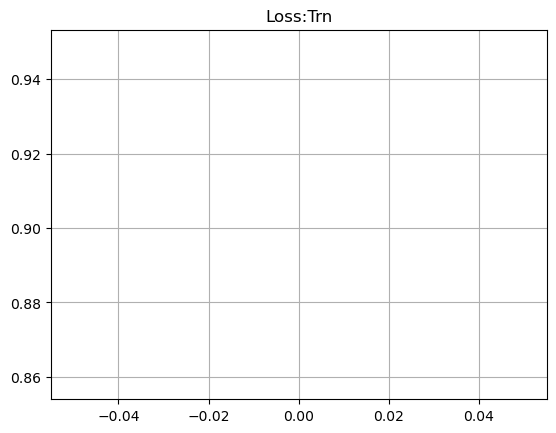

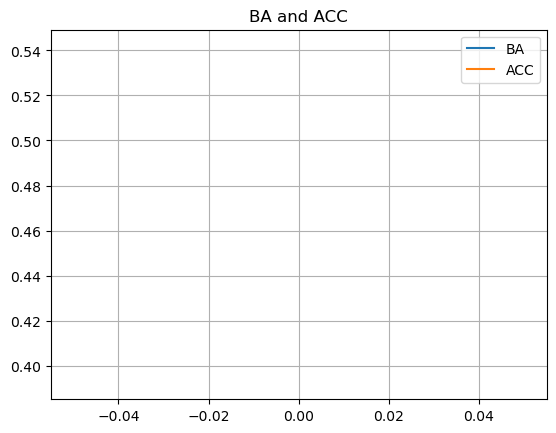

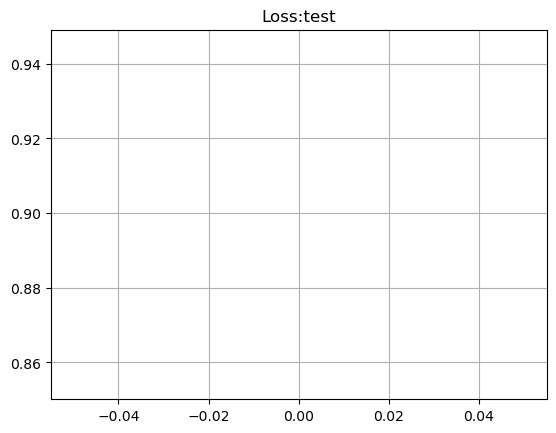

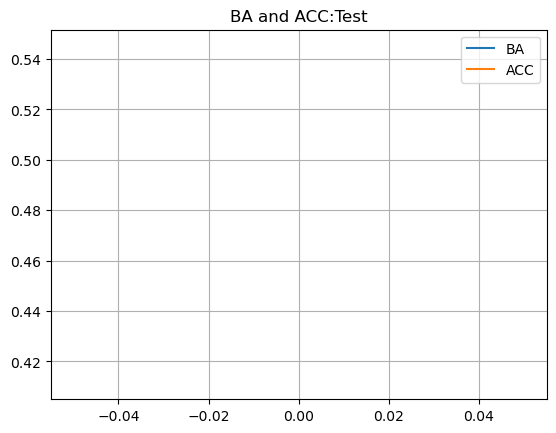

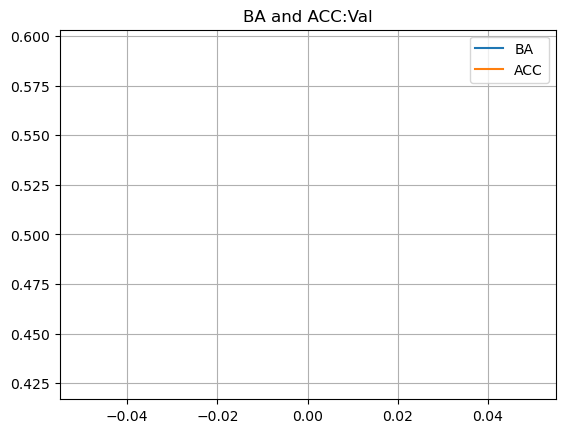

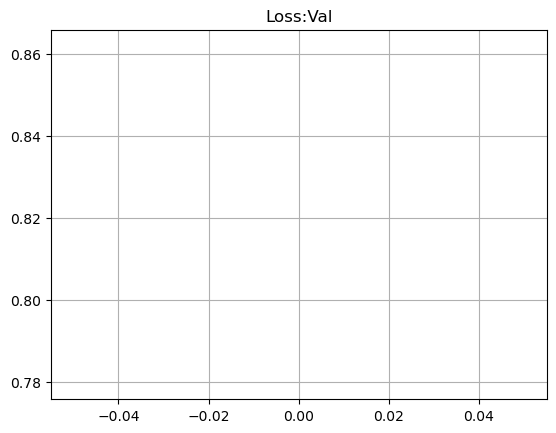

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.75it/s]


LR [9.990232305719945e-05]
Trn Loss 0.8821034
Balanced ACC 0.4156820013393719
Confusion matrix [[360   0 142]
 [ 55   0  29]
 [220   0 248]]
Acc 0.5768500948766604
Saving model for epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.37it/s]


Loss 0.80316037
Balanced ACC 0.5314305130818893
Confusion matrix [[105   0  30]
 [  6   0  14]
 [ 20   0  89]]
Acc 0.7348484848484849


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.96it/s]


Loss 0.85191846
Balanced ACC 0.525375786053253
Confusion matrix [[115   0  32]
 [  8   0  29]
 [ 40   0 154]]
Acc 0.7116402116402116
[0.8821034]
['test_acc', 'test_ba', 'test_loss', 'trn_acc', 'trn_ba', 'trn_loss', 'val_acc', 'val_ba', 'val_loss']


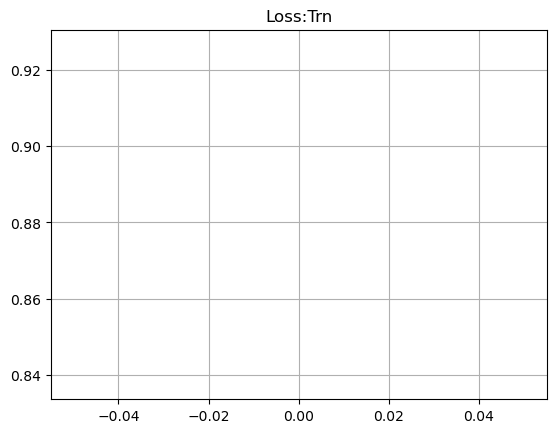

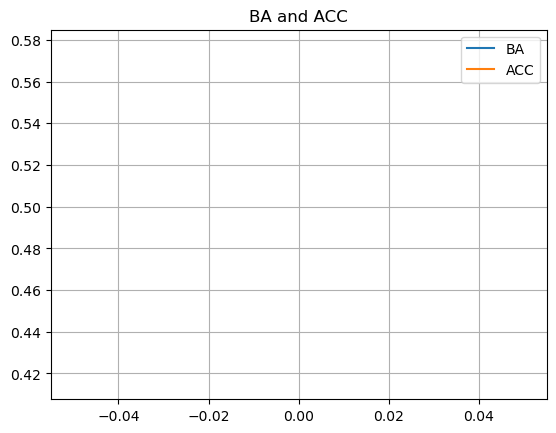

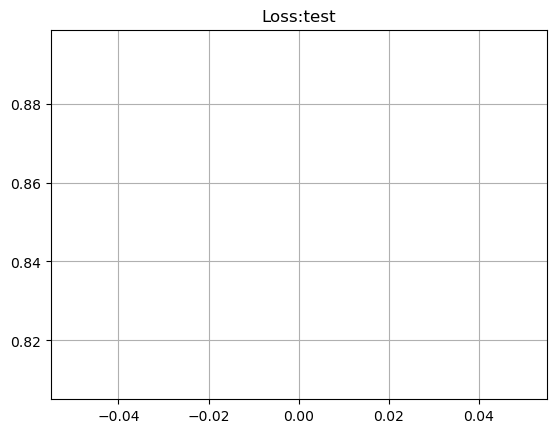

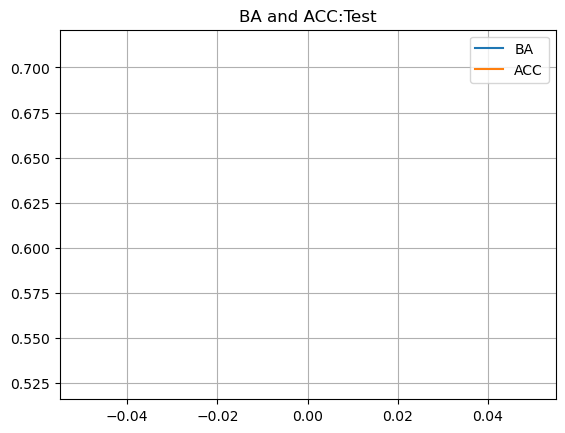

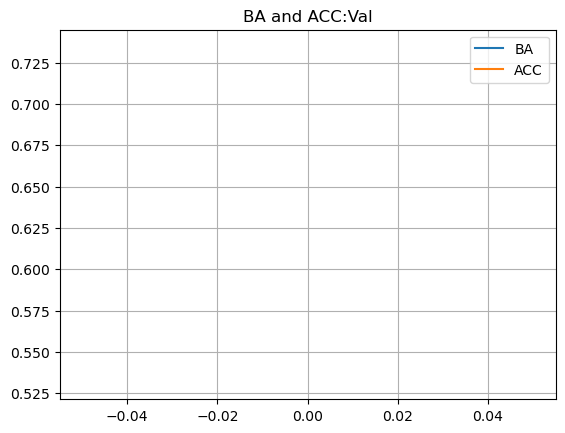

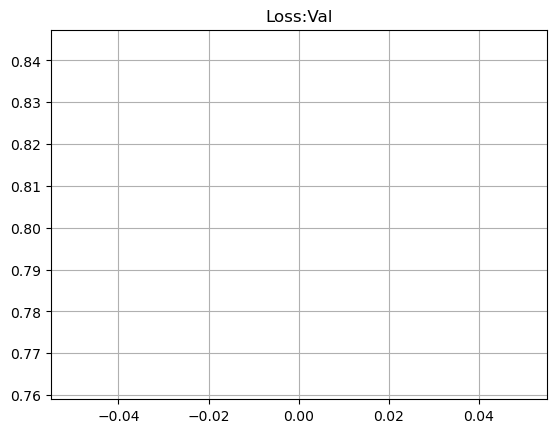

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:08<00:00,  3.68it/s]


LR [9.990232305719945e-05]
Trn Loss 0.69331694
Balanced ACC 0.5457652499485168
Confusion matrix [[397   4 101]
 [ 28   9  47]
 [111  11 346]]
Acc 0.713472485768501
Saving model for epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.60it/s]


Loss 0.50967604
Balanced ACC 0.7062068184392344
Confusion matrix [[112   0  23]
 [  2  10   8]
 [ 22   1  86]]
Acc 0.7878787878787878


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.32it/s]


Loss 0.67107934
Balanced ACC 0.5431922560052163
Confusion matrix [[117   0  30]
 [  8   3  26]
 [ 47   1 146]]
Acc 0.7037037037037037
[0.69331694]
['test_acc', 'test_ba', 'test_loss', 'trn_acc', 'trn_ba', 'trn_loss', 'val_acc', 'val_ba', 'val_loss']


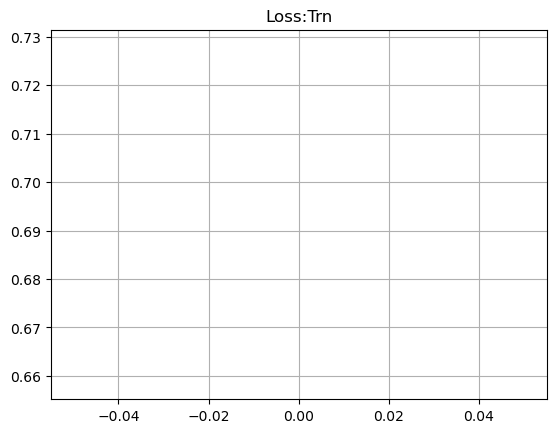

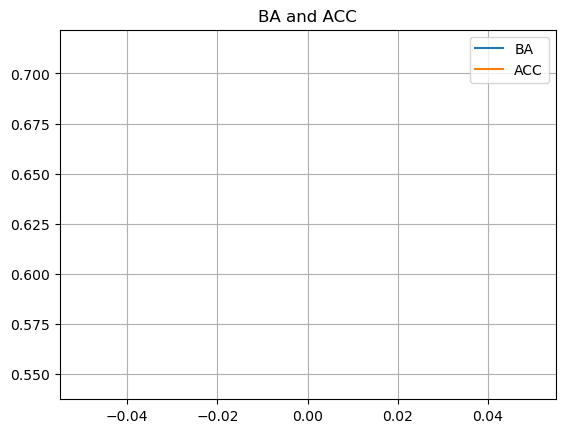

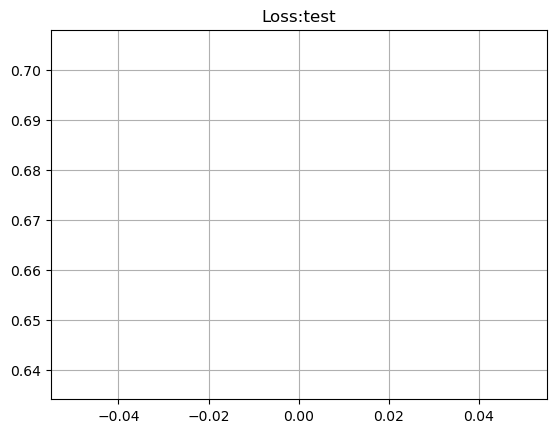

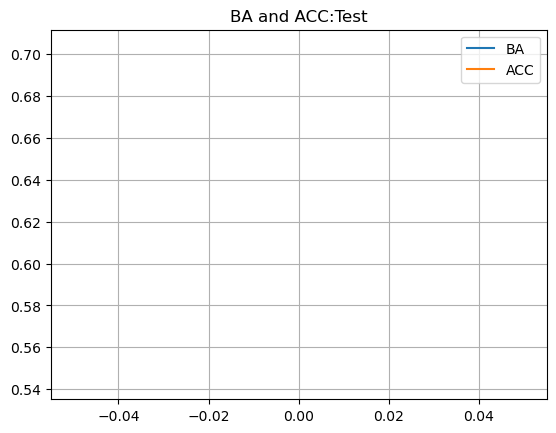

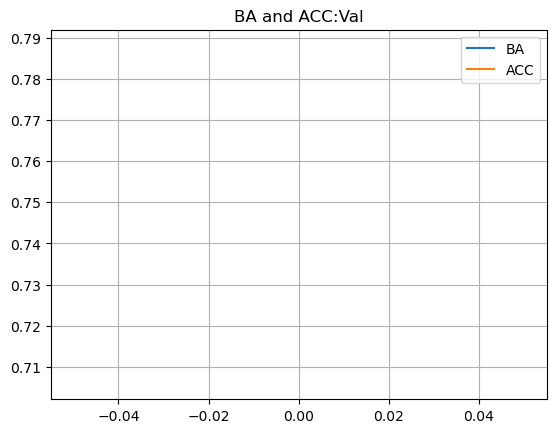

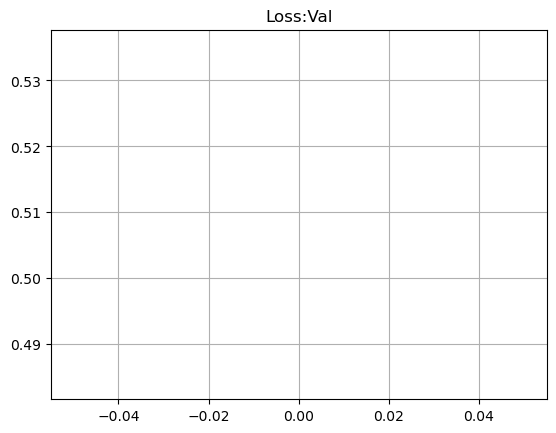

In [5]:
# Train loop
exp_base_dir = 'results_br_5' #Change accordingly with each cross validation - stores training, validation, testing information
for model_id in range(1,6):
    #Select specific model type
    if model_id == 1:
        model = resnet_model(enable_gates=False).cuda()
    if model_id == 2:    
        model = resnet_concat_model().cuda()
    if model_id == 3:    
        model = resnet_metanet_model().cuda()
    if model_id == 4:
        model = resnet_metablock_model().cuda()
    if model_id == 5:
        model = meta_fusion_model().cuda()

    #Initialize optimizer, scheduler, number of epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6) # Adam
    start_epoch=0
    num_epochs = 1
    model.cuda()

    # Initialize lists to store epoch information
    loss_list =[]
    ba_list=[]
    acc_list=[]
    ba_test_list=[]
    acc_test_list=[]
    loss_test_list =[]
    ba_val_list=[]
    acc_val_list=[]
    loss_val_list =[]
    exp_dir = exp_base_dir + "\\exp_"+str(model_id)+"\\"
    
    if not os.path.exists(exp_dir):
        os.mkdir(exp_dir)
        
    for epoch in range(start_epoch,start_epoch+num_epochs):
        model.train() 
        #Call the train_one_epoch function 
        mean_loss, ba,acc = train_one_epoch(model, optimizer, scheduler, train_loader)    
        
        model_file_name = exp_dir + "resnet_model_epoch_"+str(epoch)+".pth"
        print("Saving model for epoch", epoch)
        torch.save(model.cpu().state_dict(), model_file_name)
        loss_list.append(mean_loss)
        ba_list.append(ba)
        acc_list.append(acc)
        model.cuda()
        ba, acc, loss = eval_model(model, val_loader)
        ba_val_list.append(ba)
        acc_val_list.append(acc)
        loss_val_list.append(loss)
        ba_test, acc_test, loss_test = eval_model(model, test_loader)
        ba_test_list.append(ba_test)
        acc_test_list.append(acc_test)
        loss_test_list.append(loss_test)
    #Store the results 
    write_results(exp_dir,loss_list, ba_list, acc_list, loss_val_list, ba_val_list, acc_val_list, loss_test_list, ba_test_list, acc_test_list)        
                
